# Import Library and Data

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from scipy.interpolate import griddata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad
import torchvision
from torchvision.utils import make_grid, save_image

In [2]:
# 1) 재현성 확보
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [3]:
# 2) 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 그림 폰트 설정
plt.rcParams['font.family'] = 'Arial'

In [4]:
# 3) 데이터 로드 및 전처리
# CSV 로드
df = pd.read_csv('AlNiFe_data2.csv')

# 종속변수 및 조건변수 분리
y = df['AL'].values.astype(np.float32)

# 원-핫 인코딩
df_onehot = pd.get_dummies(df, columns=['LITHOIDX'])
cond_df = df_onehot.drop(['AL','FE','NI'], axis=1)

# 좌표 정규화: X_norm, Y_norm in [-1,1]
cond_df['X_norm'] = 2*(cond_df['X_utm'] - cond_df['X_utm'].min()) / (cond_df['X_utm'].max()-cond_df['X_utm'].min()) - 1
cond_df['Y_norm'] = 2*(cond_df['Y_utm'] - cond_df['Y_utm'].min()) / (cond_df['Y_utm'].max()-cond_df['Y_utm'].min()) - 1
# 원본 좌표 제거
cond_df = cond_df.drop(['X_utm','Y_utm'], axis=1)

# Train/Val/Test 분할 (70%/20%/10%)
X_train_df, X_temp_df, y_train, y_temp = train_test_split(cond_df, y, test_size=0.3, random_state=seed)
X_val_df, X_test_df, y_val, y_test    = train_test_split(X_temp_df, y_temp, test_size=1/3, random_state=seed)

In [5]:
# 4) 피처 스케일링
scaler_cond = StandardScaler()
X_train = scaler_cond.fit_transform(X_train_df.values).astype(np.float32)
X_val   = scaler_cond.transform(X_val_df.values).astype(np.float32)
X_test  = scaler_cond.transform(X_test_df.values).astype(np.float32)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).astype(np.float32).flatten()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1,1)).astype(np.float32).flatten()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1)).astype(np.float32).flatten()

# cGAN 학습

In [6]:
# Dataset & DataLoader 정의
class CondDataset(Dataset):
    def __init__(self, cond_array, y_array):
        self.cond = torch.from_numpy(cond_array)
        self.y    = torch.from_numpy(y_array).unsqueeze(-1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.cond[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(CondDataset(X_train, y_train_scaled), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(CondDataset(X_val,   y_val_scaled),   batch_size=batch_size, shuffle=False)

In [7]:
# 1) Self-Attention block 정의
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key   = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # x: (B, C)
        Q = self.query(x)  # (B, C)
        K = self.key(x)    # (B, C)
        V = self.value(x)  # (B, C)
        # attention map f: (B, C, C)
        f = torch.bmm(Q.unsqueeze(2), K.unsqueeze(1))
        beta = F.softmax(f, dim=-1)               # (B, C, C)
        o = torch.bmm(beta, V.unsqueeze(2)).squeeze(2)  # (B, C)
        out = self.gamma * o + x
        return out

In [8]:
# Generator & Critic 정의
class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(noise_dim + cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.att = SelfAttention(hidden_dim)       # ← 추가
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.att(x)                            # ← self-attention 적용
        return self.fc3(x)


class Critic(nn.Module):
    def __init__(self, cond_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(1 + cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.att = SelfAttention(hidden_dim)       # ← 추가
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, y, c):
        x = torch.cat([y, c], dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.att(x)                            # ← self-attention 적용
        return self.fc3(x)                         # WGAN-GP이므로 Sigmoid 제거

noise_dim = 32
cond_dim  = X_train.shape[1]

# Gradient penalty 함수
def gradient_penalty(critic, real_y, fake_y, cond, λ=10):
    batch_size = real_y.size(0)
    # ε ∈ [0,1]
    ε = torch.rand(batch_size, 1, device=device)
    y_interp = ε * real_y + (1-ε) * fake_y
    y_interp.requires_grad_(True)

    # Critic 출력
    out = critic(y_interp, cond)

    # ∂D/∂y_interp
    grads = grad(
        outputs=out,
        inputs=y_interp,
        grad_outputs=torch.ones_like(out),
        create_graph=True,
        retain_graph=True
    )[0]  # shape (batch_size,1)

    grad_norm = grads.view(batch_size, -1).norm(2, dim=1)  # L2 norm per sample
    gp = λ * ((grad_norm - 1) ** 2).mean()
    return gp

In [9]:
def train_and_validate_wgangp_coordfeat_sa(
    noise_dim, cond_dim, hidden_dim,
    lr, beta1, beta2, lambda_l1,
    train_loader, val_loader,
    scaler_y, n_critic=5, patience=10, epochs=100, device='cpu'
):
    # 1) 모델 생성 (Generator & Critic)
    G = Generator(noise_dim, cond_dim, hidden_dim).to(device)
    C = Critic(cond_dim, hidden_dim).to(device)

    # 2) 옵티마이저 (WGAN‐GP 권장 betas=(0.5,0.9) 등)
    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(beta1, beta2))

    loss_C_hist = [] # Critic Loss
    loss_G_hist = [] # Generator Loss
    val_rmse_hist = [] # Validation RMSE

    best_val_rmse = float('inf')
    wait = 0
    best_G_state = None

    # 3) 학습 루프
    for epoch in range(1, epochs+1):
        G.train(); C.train()
        
        epoch_c_loss_sum = 0
        epoch_g_loss_sum = 0
        batch_count = 0
        
        for cond_batch, y_real in train_loader:
            cond_batch, y_real = cond_batch.to(device), y_real.to(device)
            bs = cond_batch.size(0)

            # (1) Critic 업데이트 n_critic 번
            for _ in range(n_critic):
                z = torch.randn(bs, noise_dim, device=device)
                y_fake = G(z, cond_batch).detach()

                # WGAN‐GP Loss: E[C(fake)] − E[C(real)] + λ·GP
                loss_C_real = C(y_real, cond_batch).mean()
                loss_C_fake = C(y_fake, cond_batch).mean()
                gp = gradient_penalty(C, y_real, y_fake, cond_batch, λ=10)
                loss_C = loss_C_fake - loss_C_real + gp
                
                opt_C.zero_grad()
                loss_C.backward()
                opt_C.step()

            # (2) Generator 업데이트 1번
            z = torch.randn(bs, noise_dim, device=device)
            y_gen = G(z, cond_batch)
            adv_loss = -C(y_gen, cond_batch).mean()
            l1_loss = F.l1_loss(y_gen, y_real)
            loss_G = adv_loss + lambda_l1 * l1_loss

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            # Loss 누적
            epoch_c_loss_sum += loss_C.item()
            epoch_g_loss_sum += loss_G.item()
            batch_count += 1

        # 에포크 평균 Loss 저장
        avg_c_loss = epoch_c_loss_sum / batch_count
        avg_g_loss = epoch_g_loss_sum / batch_count
        loss_C_hist.append(avg_c_loss)
        loss_G_hist.append(avg_g_loss)

        
        # 4) 검증 RMSE 계산
        G.eval()
        val_rmse_list = []
        with torch.no_grad():
            for cond_batch, y_true in val_loader:
                cond_batch, y_true = cond_batch.to(device), y_true.to(device)
                z = torch.randn(cond_batch.size(0), noise_dim, device=device)
                y_pred = G(z, cond_batch)
    
                y_pred_np = scaler_y.inverse_transform(y_pred.cpu().numpy().flatten().reshape(-1,1)).flatten()
                y_true_np = scaler_y.inverse_transform(y_true.cpu().numpy().flatten().reshape(-1,1)).flatten()
                mse = mean_squared_error(y_true_np, y_pred_np)
                val_rmse_list.append(np.sqrt(mse))
                
            val_rmse = np.mean(val_rmse_list)
            val_rmse_hist.append(val_rmse)
            
            # ── (B) 조기 종료 체크 ──
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_G_state = G.state_dict()
                wait = 0
            else:
                wait += 1
            
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
                
    print(f"Training Finished. Best Val RMSE: {best_val_rmse:.4f}")
    
    # 6) 최종 반환값은 “가장 좋았던 검증 RMSE”
    return best_val_rmse, best_G_state, loss_C_hist, loss_G_hist, val_rmse_hist

In [44]:
# 랜덤 서치 루프
best_rmse = float('inf')
best_params = {}
n_iter = 30

for i in range(1, n_iter+1):
    # 하이퍼파라미터 랜덤 샘플링
    lr      = 10**np.random.uniform(-8, -2)          # [1e-5, 1e-2]
    beta1   = np.random.choice([0.5, 0.7, 0.9])
    beta2   = np.random.choice([0.9, 0.99, 0.999])
    hidden  = random.choice([64, 128, 256])
    lambda1 = 10**np.random.uniform(0, 2)            # [1, 100]

    val_rmse, best_G_state, loss_C_hist, loss_G_hist, val_rmse_hist = train_and_validate_wgangp_coordfeat_sa(
        noise_dim=noise_dim,
        cond_dim=cond_dim,
        hidden_dim=hidden,
        lr=lr,
        beta1=beta1,
        beta2=beta2,
        lambda_l1=lambda1,
        train_loader=train_loader,
        val_loader=val_loader,
        scaler_y=scaler_y,
        n_critic=5,      
        epochs=100,        
        patience=15,
        device=device
    )

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = best_G_state # 가중치 저장
        best_params = {
            'lr': lr, 'beta1': beta1, 'beta2': beta2,
            'hidden_dim': hidden, 'lambda_l1': lambda1
        }
        
        # [중요] Best 모델일 때의 Loss 기록을 따로 저장
        final_loss_C_hist = loss_C_hist
        final_loss_G_hist = loss_G_hist
        final_val_rmse_hist = val_rmse_hist
        
        print(f"Iter {i}/{n_iter} | [New Best] Val RMSE: {best_rmse:.2f}")
    else:
        print(f"Iter {i}/{n_iter} | Val RMSE: {val_rmse:.2f} (Best: {best_rmse:.2f})")

print("\n>>> Best Hyperparams:", best_params)
print(f">>> Best RMSE: {best_rmse:.4f}")

Early stopping at epoch 32
Training Finished. Best Val RMSE: 113.3376
Iter 1/30 | [New Best] Val RMSE: 113.34
Early stopping at epoch 30
Training Finished. Best Val RMSE: 114.3018
Iter 2/30 | Val RMSE: 114.30 (Best: 113.34)
Early stopping at epoch 33
Training Finished. Best Val RMSE: 114.0044
Iter 3/30 | Val RMSE: 114.00 (Best: 113.34)
Early stopping at epoch 28
Training Finished. Best Val RMSE: 101.7653
Iter 4/30 | [New Best] Val RMSE: 101.77
Early stopping at epoch 20
Training Finished. Best Val RMSE: 108.7533
Iter 5/30 | Val RMSE: 108.75 (Best: 101.77)
Training Finished. Best Val RMSE: 98.9470
Iter 6/30 | [New Best] Val RMSE: 98.95
Early stopping at epoch 20
Training Finished. Best Val RMSE: 116.0549
Iter 7/30 | Val RMSE: 116.05 (Best: 98.95)
Early stopping at epoch 52
Training Finished. Best Val RMSE: 112.4445
Iter 8/30 | Val RMSE: 112.44 (Best: 98.95)
Early stopping at epoch 19
Training Finished. Best Val RMSE: 110.7878
Iter 9/30 | Val RMSE: 110.79 (Best: 98.95)
Early stopping at 

In [45]:
# 하이퍼파라미터 할당
best = best_params.copy()
from sklearn.model_selection import ParameterGrid

lr_vals     = np.logspace(np.log10(best['lr']/3), np.log10(best['lr']*3), num=5)
beta1_vals  = [best['beta1']]    # 굳이 변화가 필요 없으면 고정
beta2_vals  = [best['beta2']]
hidden_vals = [32, 64, 96]
lambda_vals = np.logspace(np.log10(best['lambda_l1']/3), np.log10(best['lambda_l1']*3), num=5)

param_grid = {
    'lr'       : lr_vals,
    'beta1'    : beta1_vals,
    'beta2'    : beta2_vals,
    'hidden_dim': hidden_vals,
    'lambda_l1': lambda_vals
}

grid = list(ParameterGrid(param_grid))
print(f"총 탐색 조합 수: {len(grid)}")

총 탐색 조합 수: 75


In [46]:
# 그리드 서치 루프
best_rmse_grid = float('inf')
best_params_grid = None

for i, params in enumerate(grid, 1):
        
    val_rmse, best_G_state, loss_C_hist, loss_G_hist, val_rmse_hist = train_and_validate_wgangp_coordfeat_sa(
        noise_dim=noise_dim,
        cond_dim=cond_dim,
        hidden_dim=params['hidden_dim'],
        lr=params['lr'],
        beta1=params['beta1'],
        beta2=params['beta2'],
        lambda_l1=params['lambda_l1'],
        train_loader=train_loader,
        val_loader=val_loader,
        scaler_y=scaler_y,
        epochs=100,
        patience=15,
        device=device
    )
    if val_rmse < best_rmse_grid:
        best_rmse_grid = val_rmse
        best_params_grid = params.copy()
    print(f"[Grid {i}/{len(grid)}] RMSE: {val_rmse:.2f}  params: {params}")

print("→ Grid Search Best params:", best_params_grid, "| Val RMSE:", best_rmse_grid)

Early stopping at epoch 18
Training Finished. Best Val RMSE: 116.9094
[Grid 1/75] RMSE: 116.91  params: {'beta1': np.float64(0.9), 'beta2': np.float64(0.99), 'hidden_dim': 32, 'lambda_l1': np.float64(0.6496336154114749), 'lr': np.float64(0.0009385859764770569)}
Early stopping at epoch 21
Training Finished. Best Val RMSE: 110.3984
[Grid 2/75] RMSE: 110.40  params: {'beta1': np.float64(0.9), 'beta2': np.float64(0.99), 'hidden_dim': 32, 'lambda_l1': np.float64(0.6496336154114749), 'lr': np.float64(0.0016256785985299099)}
Early stopping at epoch 16
Training Finished. Best Val RMSE: 118.9089
[Grid 3/75] RMSE: 118.91  params: {'beta1': np.float64(0.9), 'beta2': np.float64(0.99), 'hidden_dim': 32, 'lambda_l1': np.float64(0.6496336154114749), 'lr': np.float64(0.0028157579294311717)}
Early stopping at epoch 16
Training Finished. Best Val RMSE: 122.9450
[Grid 4/75] RMSE: 122.94  params: {'beta1': np.float64(0.9), 'beta2': np.float64(0.99), 'hidden_dim': 32, 'lambda_l1': np.float64(0.649633615411

In [47]:
# 8.1) best_params 반영
lr        = best_params['lr']
beta1     = best_params['beta1']
beta2     = best_params['beta2']
hidden_dim= best_params['hidden_dim']
lambda_l1 = best_params['lambda_l1']

# 2) Generator & Critic 인스턴스 생성
G_final = Generator(noise_dim, cond_dim, hidden_dim).to(device)
C_final = Critic(cond_dim, hidden_dim).to(device)

opt_G = torch.optim.Adam(G_final.parameters(), lr=lr, betas=(beta1, beta2))
opt_C = torch.optim.Adam(C_final.parameters(), lr=lr, betas=(beta1, beta2))
criterion = nn.BCELoss()

In [48]:
# 8.3) train_loader + val_loader 합치기
from torch.utils.data import ConcatDataset
train_ds = CondDataset(X_train, y_train_scaled)
val_ds   = CondDataset(X_val,   y_val_scaled)
full_train_ds     = ConcatDataset([train_ds, val_ds])
full_train_loader = DataLoader(full_train_ds, batch_size=batch_size, shuffle=True)

test_ds = CondDataset(X_test, y_test_scaled)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False) 

In [49]:
# 8.4) 최종 학습 (epochs=200)
final_epochs = 200
n_critic     = 5

final_C_losses = []
final_G_losses = []
final_Val_RMSE = []

for epoch in range(1, final_epochs+1):
    G_final.train(); C_final.train()
    
    # 에포크별 평균 Loss 계산용 변수
    epoch_c_sum = 0
    epoch_g_sum = 0
    batch_count = 0
    
    for cond_batch, y_real in full_train_loader:
        cond_batch, y_real = cond_batch.to(device), y_real.to(device)
        bs = cond_batch.size(0)
        
        # (1) Critic 업데이트 n_critic 번
        for _ in range(n_critic):
            z = torch.randn(bs, noise_dim, device=device)
            y_fake = G_final(z, cond_batch).detach()

            loss_C_real = C_final(y_real, cond_batch).mean()
            loss_C_fake = C_final(y_fake, cond_batch).mean()
            gp = gradient_penalty(C_final, y_real, y_fake, cond_batch, λ=10)

            loss_C = loss_C_fake - loss_C_real + gp
            opt_C.zero_grad()
            loss_C.backward()
            opt_C.step()

        # (2) Generator 업데이트 1번
        z       = torch.randn(bs, noise_dim, device=device)
        y_gen   = G_final(z, cond_batch)
        adv_loss = -C_final(y_gen, cond_batch).mean()
        l1_loss  = F.l1_loss(y_gen, y_real)
        loss_G   = adv_loss + lambda_l1 * l1_loss

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        
        epoch_c_sum += loss_C.item()
        epoch_g_sum += loss_G.item()
        batch_count += 1

    avg_c = epoch_c_sum / batch_count
    avg_g = epoch_g_sum / batch_count
    final_C_losses.append(avg_c)
    final_G_losses.append(avg_g)

    G_final.eval()
    temp_rmse_list = []
    with torch.no_grad():
        target_loader = test_loader if 'test_loader' in locals() else full_train_loader 
        
        for cond_b, y_b in target_loader:
            cond_b, y_b = cond_b.to(device), y_b.to(device)
            z_val = torch.randn(cond_b.size(0), noise_dim, device=device)
            y_p = G_final(z_val, cond_b)
            
            # 역정규화
            y_p_inv = scaler_y.inverse_transform(y_p.cpu().numpy()).flatten()
            y_b_inv = scaler_y.inverse_transform(y_b.cpu().numpy()).flatten()
            
            temp_rmse_list.append(np.sqrt(mean_squared_error(y_b_inv, y_p_inv)))
            
    epoch_val_rmse = np.mean(temp_rmse_list)
    final_Val_RMSE.append(epoch_val_rmse)

    # (선택) 손실 모니터링
    if epoch % 20 == 0 or epoch == 1:
        print(f"Final Epoch {epoch:03d} | Critic Loss: {loss_C.item():.4f} | Gen Loss: {loss_G.item():.4f}")

Final Epoch 001 | Critic Loss: 0.8787 | Gen Loss: 0.9219
Final Epoch 020 | Critic Loss: 0.4019 | Gen Loss: -1.0398
Final Epoch 040 | Critic Loss: 0.4105 | Gen Loss: -1.1221
Final Epoch 060 | Critic Loss: 0.2148 | Gen Loss: -2.4891
Final Epoch 080 | Critic Loss: 0.2768 | Gen Loss: -2.3199
Final Epoch 100 | Critic Loss: 0.3361 | Gen Loss: -2.3519
Final Epoch 120 | Critic Loss: 0.2618 | Gen Loss: -3.0538
Final Epoch 140 | Critic Loss: 0.4248 | Gen Loss: -2.0174
Final Epoch 160 | Critic Loss: 0.2834 | Gen Loss: -2.4483
Final Epoch 180 | Critic Loss: 0.3328 | Gen Loss: -1.9137
Final Epoch 200 | Critic Loss: 0.0741 | Gen Loss: -2.3545


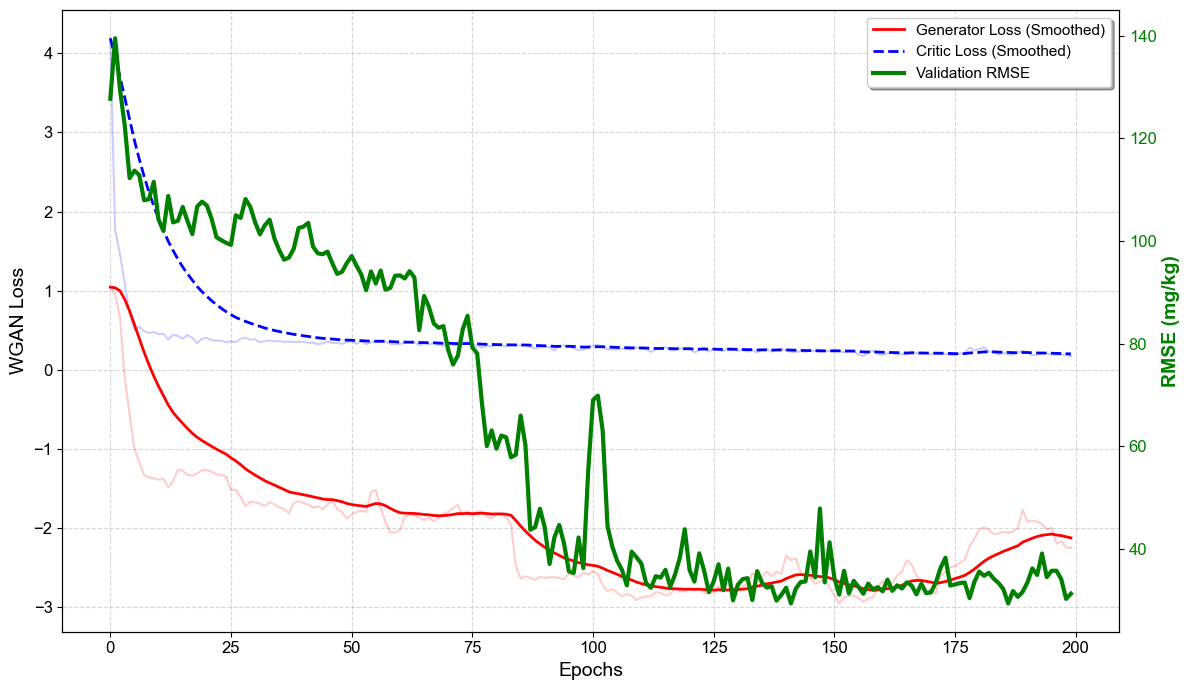

In [50]:
# 그래프 설정
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_G = smooth_curve(final_G_losses)
smooth_C = smooth_curve(final_C_losses)

plt.figure(figsize=(12, 7)) # 논문용으로 적절한 비율 (14,8은 너무 큼)

ax1 = plt.gca()

# --- [Left Axis] WGAN Losses ---
# 1) 원본 데이터 (Raw Data) - 흐리게 (alpha=0.2)
ax1.plot(final_G_losses, color='red', alpha=0.2) 
ax1.plot(final_C_losses, color='blue', alpha=0.2)

# 2) 스무딩 데이터 (Smoothed Data) - 진하게 (alpha=1.0)
l1 = ax1.plot(smooth_G, label='Generator Loss (Smoothed)', color='red', linewidth=2)
l2 = ax1.plot(smooth_C, label='Critic Loss (Smoothed)', color='blue', linewidth=2, linestyle='--')

ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('WGAN Loss', fontsize=14)
ax1.grid(True, which='major', linestyle='--', alpha=0.5)

# --- [Right Axis] Validation RMSE ---
ax2 = ax1.twinx()
# RMSE는 스무딩 없이 원본을 보여주는 것이 일반적입니다 (급격한 하락 포인트를 정확히 보여주기 위해)
l3 = ax2.plot(final_Val_RMSE, label='Validation RMSE', color='green', linewidth=3)
ax2.set_ylabel('RMSE (mg/kg)', color='green', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
ax1.tick_params(axis='both', labelsize=12)

# --- [Legend] 범례 통합 ---
lines = l1 + l2 + l3
labels = [l.get_label() for l in lines]
# 범례 위치를 'center right' 등으로 조정하여 그래프를 가리지 않게 설정
ax1.legend(lines, labels, loc='upper right', frameon=True, fontsize=11, shadow=True)

#plt.title('Training Stability & Generalization (GSA-cGAN)', fontsize=16, pad=15)
plt.tight_layout()

# 캡션에 "EMA smoothing (factor=0.9) applied for visual clarity" 문구 추가 필수
plt.savefig('Final_Loss_Curve.png', dpi=300)
plt.show()

In [314]:
# 8.5) 테스트셋 평가 및 시각화
G_final.eval()
with torch.no_grad():
    z = torch.randn(len(X_test), noise_dim, device=device)
    al_synth_scaled = G_final(z, torch.from_numpy(X_test).to(device)).cpu().numpy().flatten()
    al_synth = scaler_y.inverse_transform(al_synth_scaled.reshape(-1,1)).flatten()

rmse_test = root_mean_squared_error(y_test, al_synth)
r2_test   = r2_score(y_test, al_synth)
print(f"Test RMSE: {rmse_test:.2f} | R²: {r2_test:.3f}")

Test RMSE: 29.56 | R²: 0.940


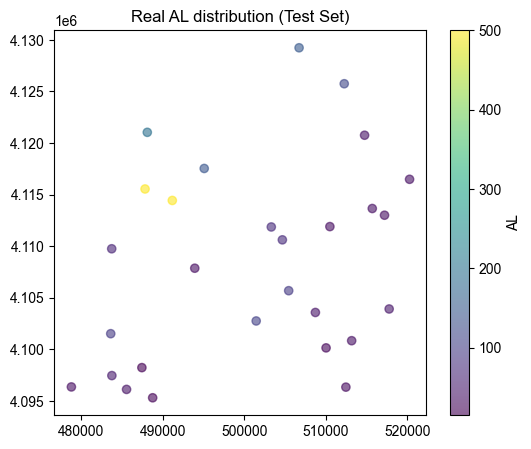

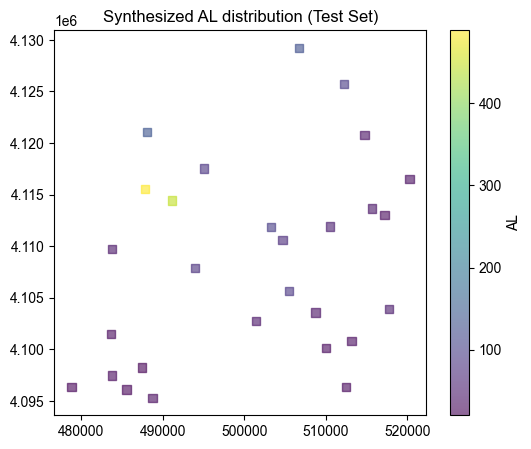

In [315]:
# (UTM 좌표 기준 산점도)
coords_x = df.loc[X_test_df.index, 'X_utm'].values
coords_y = df.loc[X_test_df.index, 'Y_utm'].values

plt.figure(figsize=(6,5))
plt.scatter(coords_x, coords_y, c=y_test, cmap='viridis', marker='o', alpha=0.6)
plt.title('Real AL distribution (Test Set)')
plt.colorbar(label='AL'); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(coords_x, coords_y, c=al_synth, cmap='viridis', marker='s', alpha=0.6)
plt.title('Synthesized AL distribution (Test Set)')
plt.colorbar(label='AL'); plt.show()

# 보조 변수 활용 

In [316]:
# 1) 보조 데이터 로드
Aux = pd.read_csv('Auxiliary_data2.csv')

In [317]:
# 2) 원-핫 인코딩 & 불필요 컬럼 제거
Aux_one_hot = pd.get_dummies(Aux, columns=['LITHOIDX'])
Aux_cond = Aux_one_hot.drop(['AL','NI','FE'], axis=1)

In [318]:
# 학습 시 사용한 cond_df.columns 순서·개수에 맞춰 정렬
Aux_cond = Aux_cond.reindex(columns=cond_df.columns, fill_value=0)

In [319]:
# 스케일링
X_aux_np = scaler_cond.transform(Aux_cond.values.astype(np.float32))

In [320]:
# Tensor 변환 & 생성기 입력 준비
cond_aux = torch.from_numpy(X_aux_np).to(device)
z = torch.randn(len(X_aux_np), noise_dim, device=device)

In [321]:
# 6) 생성기(G) 통과 → 스케일 복원
G_final.eval()
with torch.no_grad():
    y_synth_scaled = G_final(z, cond_aux).cpu().numpy()              # shape (n,1)
y_synth = scaler_y.inverse_transform(y_synth_scaled).flatten()  # 원스케일 AL

In [322]:
# 7) 결과를 좌표와 합쳐 DataFrame으로
df_aux = pd.DataFrame({
    'X': Aux['X_utm'],
    'Y': Aux['Y_utm'],
    'AL_synth': y_synth
})

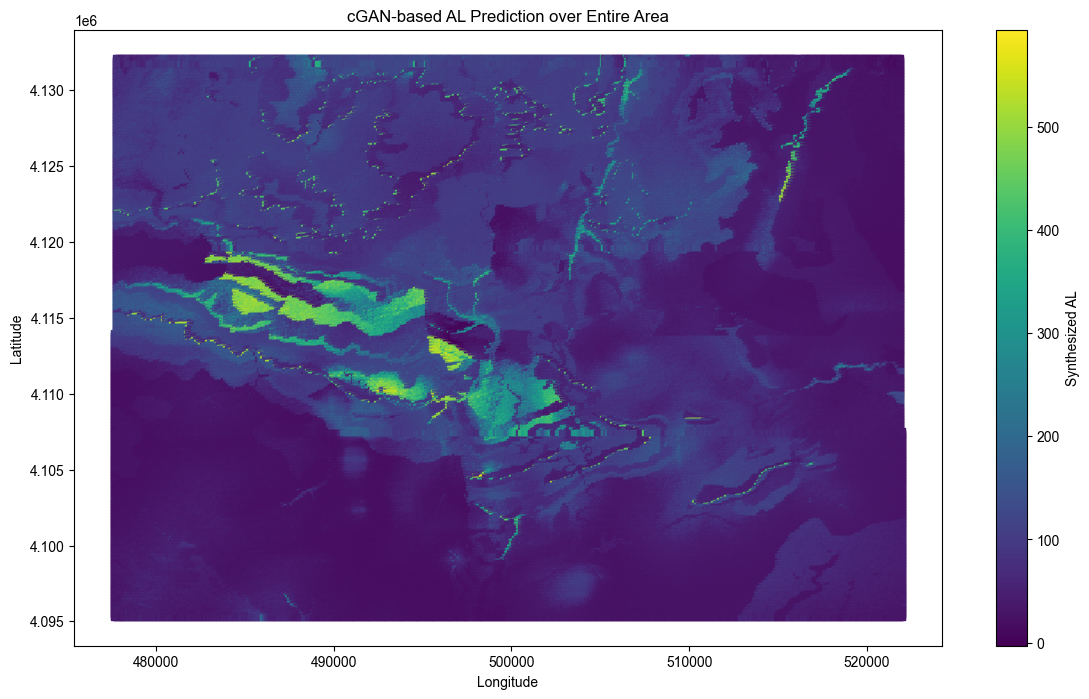

In [323]:
# 공간 분포 시각화 (scatter)
plt.figure(figsize=(14,8))
plt.scatter(df_aux['X'], df_aux['Y'],
            c=df_aux['AL_synth'], cmap='viridis',
            s=15, marker='s')
plt.colorbar(label='Synthesized AL')
plt.title('cGAN-based AL Prediction over Entire Area')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

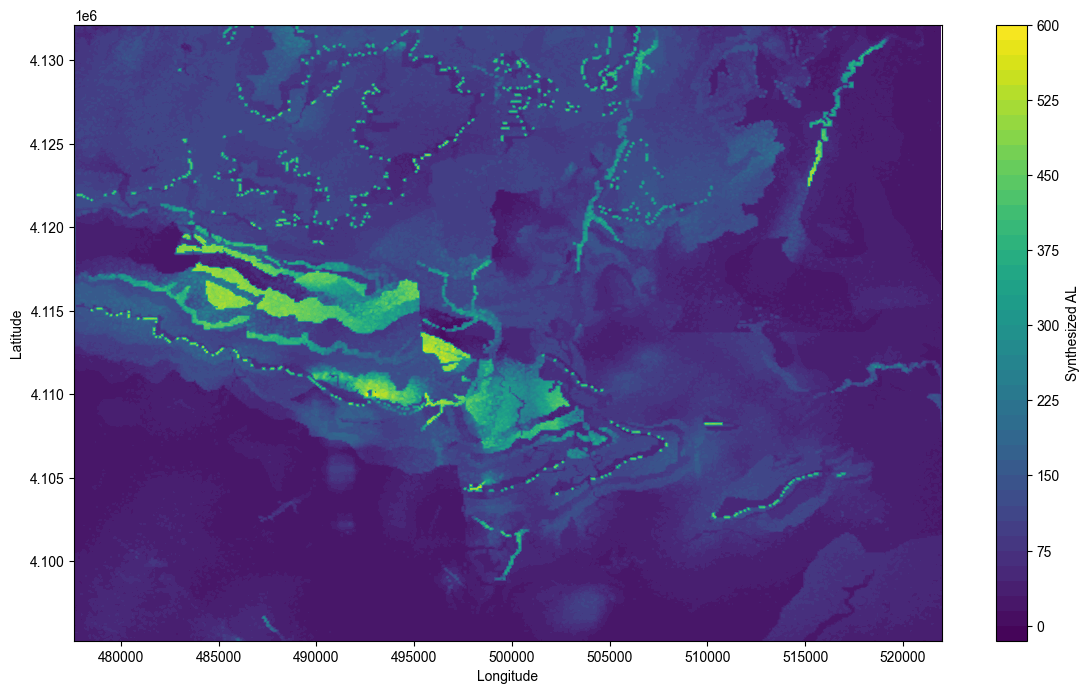

In [324]:
# 공간 분포 시각화 (contourf)
# 원본 좌표·값 배열
x = df_aux['X'].values
y = df_aux['Y'].values
z = df_aux['AL_synth'].values

# 그리드 생성 (조밀도 설정)
xi = np.linspace(x.min(), x.max(), 4440)
yi = np.linspace(y.min(), y.max(), 3690)
Xi, Yi = np.meshgrid(xi, yi)

# 보간 (cubic / linear / nearest 중 선택)
Zi = griddata((x, y), z, (Xi, Yi), method='linear')

# contourf 그리기
plt.figure(figsize=(14,8))
cf = plt.contourf(Xi, Yi, Zi, levels=50, cmap='viridis')
plt.colorbar(cf, label='Synthesized AL')

#plt.title('cGAN-based AL Prediction over Entire Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [325]:
y_synth.max(), y_synth.min(), y_synth.mean()

(np.float32(594.31366), np.float32(-3.078064), np.float32(81.79933))

## 임의의 좌표에 대하여 G를 활용한 예측

Test RMSE: 29.68 | MAE: 20.86 | MAPE: 0.33 | R²: 0.940


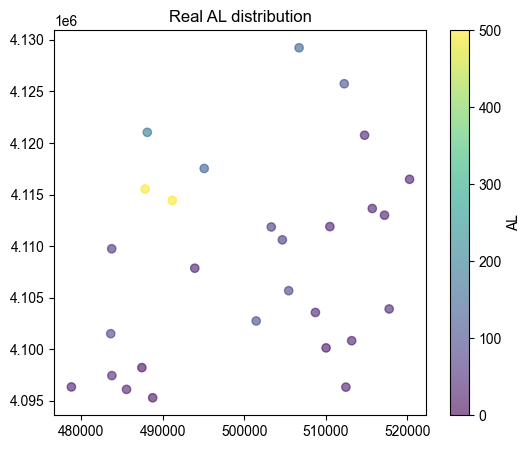

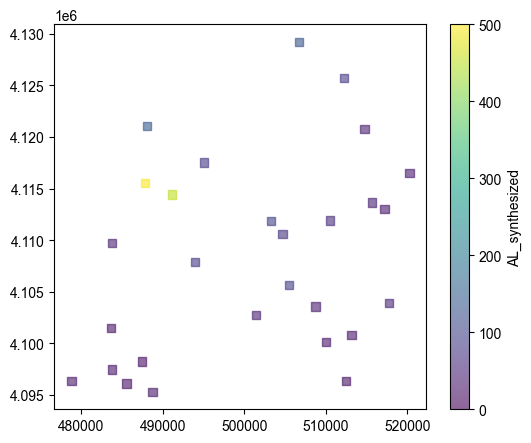

In [333]:
# 테스트용 cond 벡터
cond_test = torch.from_numpy(X_test).to(device)  # shape (N, cond_dim)|

# G 직접 호출
G_final.eval()
with torch.no_grad():
    z = torch.randn(len(cond_test), noise_dim, device=device)
    al_pred_scaled = G_final(z, cond_test).cpu().numpy().flatten()
    al_pred = scaler_y.inverse_transform(al_pred_scaled.reshape(-1,1)).flatten()

# 오차 평가
rmse = root_mean_squared_error(y_test, al_pred)
mae = mean_absolute_error(y_test, al_pred)
mape = mean_absolute_percentage_error(y_test, al_pred)
r2   = r2_score(y_test, al_pred)
print(f"Test RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f} | R²: {r2:.3f}")

# 시각화
plt.figure(figsize=(6,5))
plt.scatter(df.loc[X_test_df.index,'X_utm'], 
            df.loc[X_test_df.index,'Y_utm'], 
            c=y_test, cmap='viridis', 
            marker='o', alpha=0.6, vmin=0, vmax=500)
plt.title('Real AL distribution'); plt.colorbar(label='AL'); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df.loc[X_test_df.index,'X_utm'], 
            df.loc[X_test_df.index,'Y_utm'], 
            c=al_pred, cmap='viridis', 
            marker='s', alpha=0.6, vmin=0, vmax=500)
#plt.title('Synthesized AL distribution')
plt.colorbar(label='AL_synthesized'); plt.show()

## Test 지점 잔차 계산

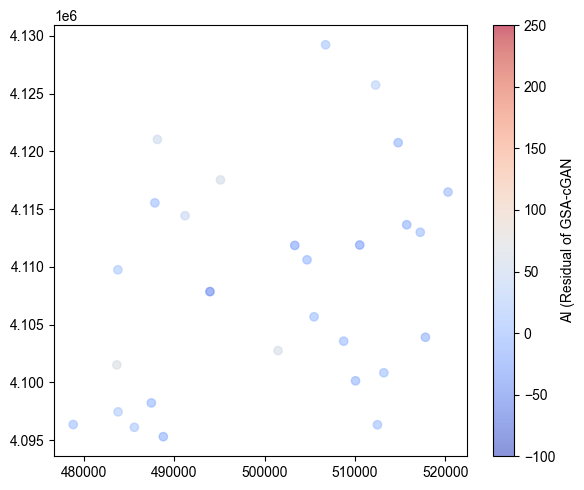

In [336]:
residual_cGAN = y_test - al_pred

plt.figure(figsize=(6,5))
plt.scatter(df.loc[X_test_df.index,'X_utm'], 
            df.loc[X_test_df.index,'Y_utm'], 
            c=residual_cGAN, cmap='coolwarm', 
            marker='o', alpha=0.6, vmin=-100, vmax=250)
#plt.title('Residual of Basic cGAN'); 
plt.colorbar(label='Al (Residual of GSA-cGAN')
plt.tight_layout()
plt.savefig('Difference_Map_GSA-cGAN.png', dpi=300)
plt.show()

# prediction extract

In [79]:
data = pd.read_csv('my_data.csv')

data['GSA-cGAN'] = al_pred

data.to_csv('my_data.csv', index=False)